# PDF Processing

This notebook focuses on extracting structured data from LEGO instruction manuals in PDF format. Specifically, we'll use tools for computer vision, OCR and image processing to identify and catalog which LEGO pieces are used in each construction step of a LEGO set by analyzing the manual's PDF content.

The primary goal is to create an automatic tool for parsing LEGO instruction PDFs and generating a comprehensive inventory of pieces organized by construction step. From this information we'll create a database which we'll use later on.

### Imports and definitions

In [ ]:
from pathlib import Path
import pandas as pd
import sys
import os

# Get the absolute path of the current directory
current_dir = Path().resolve()
# If we're in the notebooks or src directory, move up one level
# to the project root directory
project_root = current_dir.parent if current_dir.name in ['notebooks', 'src'] else current_dir
# Add the project root directory to Python's path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
# Add /src to Python's path
src_dir = project_root / 'src'
if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))

# Change the current working directory
os.chdir(project_root)

from src.pdf_processor import PDFProcessor
from src.db_interface import DatabaseInterface
import src.step_detector
import csv
from src.utils.logger import setup_logging

setup_logging(log_to_console=False)

data_dir = Path('data')
images_path = data_dir / 'training' / 'images'
manuals_path = data_dir / 'training' / 'manuals'
manuals_to_sets = manuals_path / 'manuals_to_sets.csv'
processed_booklets_dir = data_dir / 'processed_booklets'
annotations_file_path = data_dir / 'training' / 'annotations' / 'merged' / 'annotations.json'
db_path = data_dir / 'brickmapper.db'

## Training the YOLO Model

YOLO is used to identify step data in the LEGO manuals.
About 500 pages from 4 different manuals were annotated using [CVAT](https://www.cvat.ai/), split into training, validation and test sets (60%, 20%, 20% respectively) and used to train a YOLO11 n model, 
 11 being the latest YOLO version. The 'n' model was chosen due to its size, and has proven to be more than adequate for the task.

Here's an example of an annotated page:
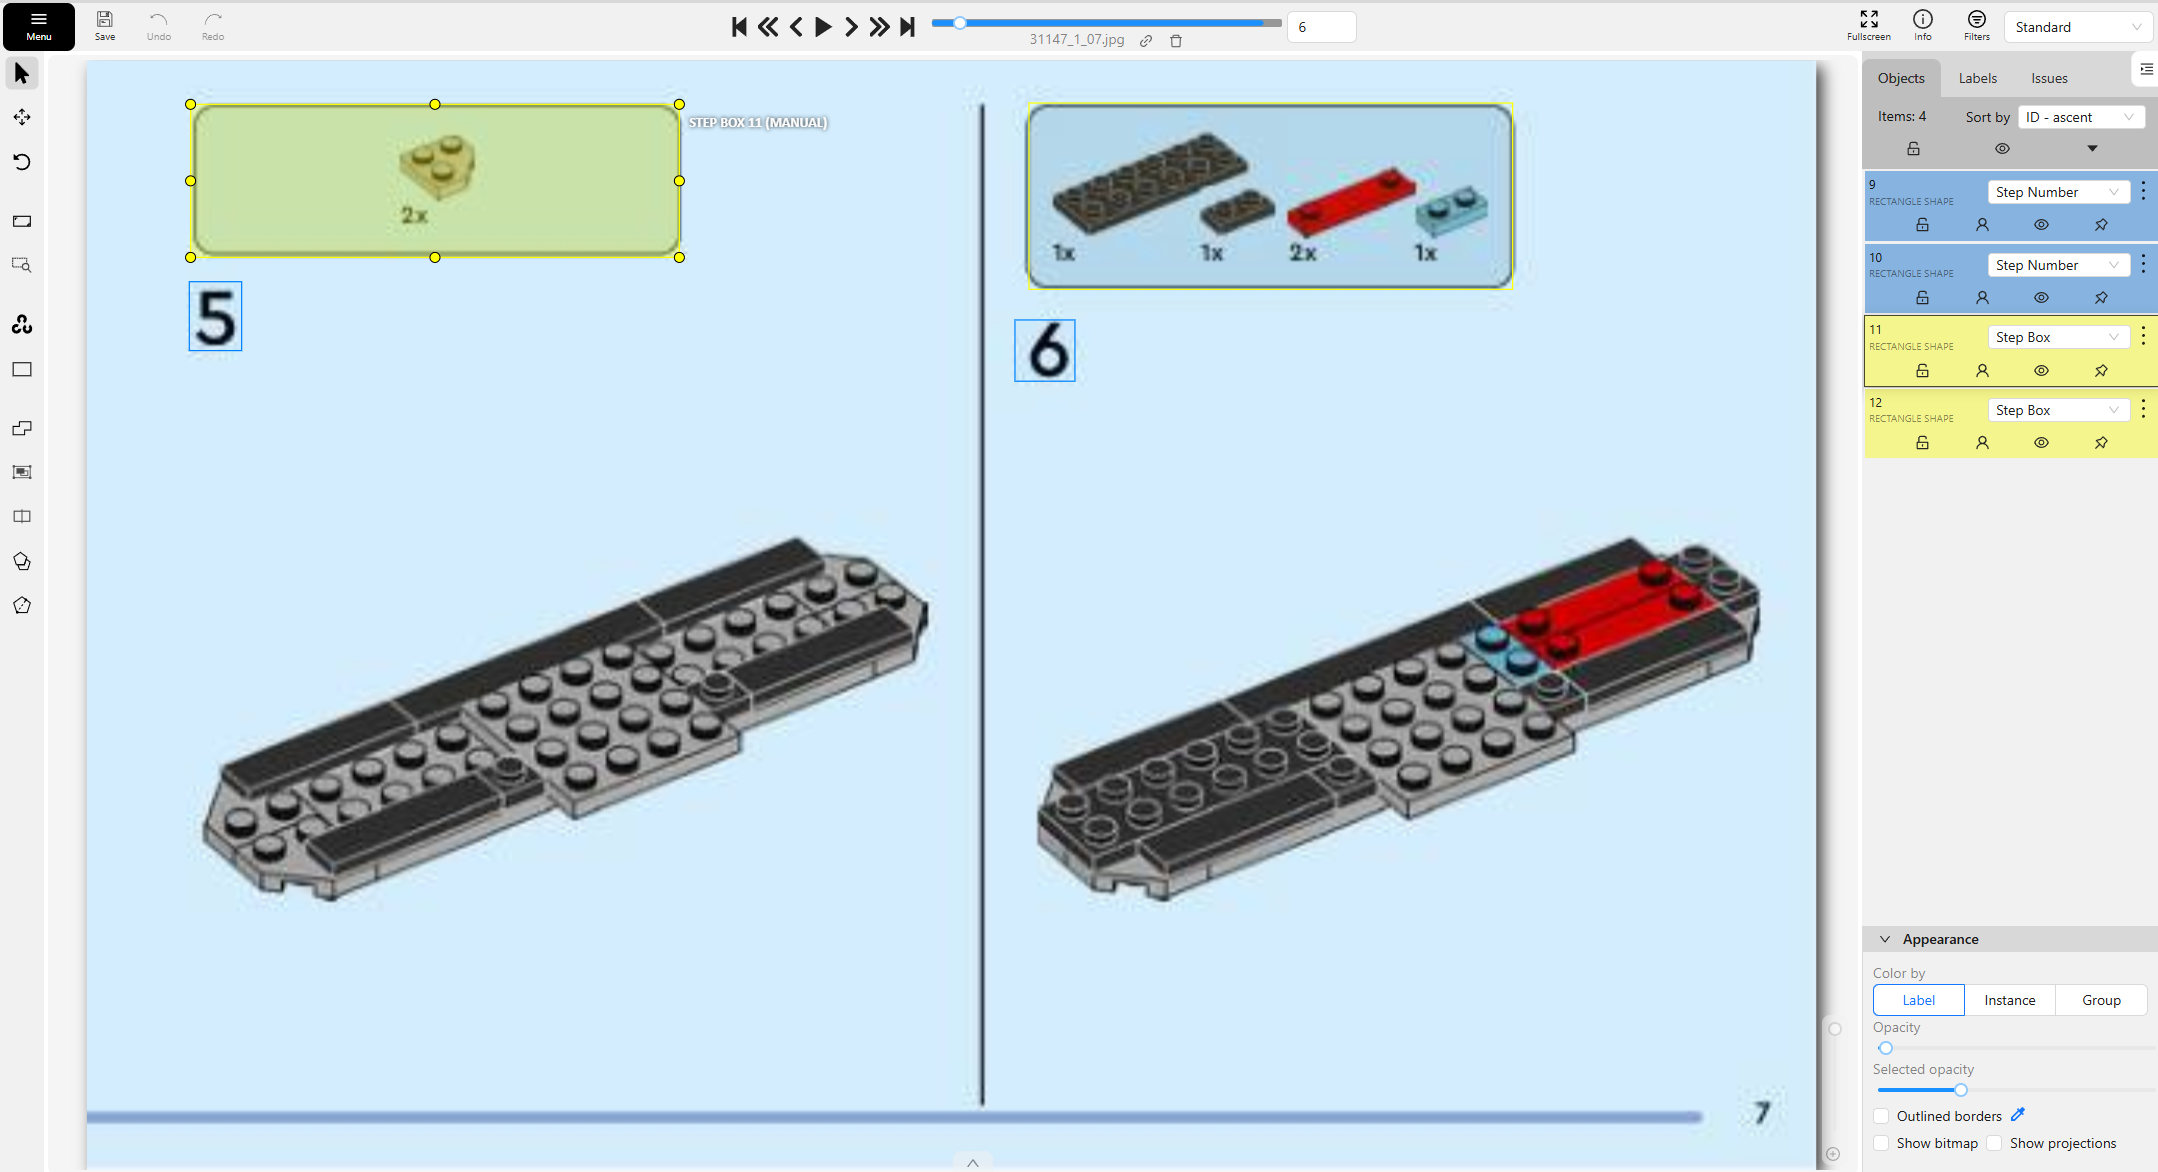

There are two types of annotations:
* Yellow boxes denote step boxes (Where all the parts used for this step are listed)
* Blue boxes denote the step number. Step numbers are usually incremented throughout the build process, but they can some times reset when switching to a new manual, or even within the same manual.
So to make sure location pointers are unique we'll use the set number, booklet number, page number and step number when saving a piece's usage.

In [2]:
# If the model has already been trained, we don't need to train it again
model_path = Path("runs/train/exp/weights/best.pt")

if not model_path.exists():
    step_detector.train_model(images_dir=images_path, annotations_path = annotations_file_path, model_save_path=model_path)

## Processing manuals

Now that the model has been trained we can use it to process manuals it hasn't seen yet.

To process a manual, the following steps should be taken:

* Put a PDF of the manual in `manuals_path`
* Add the manual to the `manuals_to_sets` csv file (Format: manual_ID,set_number,booklet_number)
* Add the manual ID and piece list pages to the `manuals` list below and the:

In [2]:
manuals = [('6497660', [37, 38])]

In [ ]:
# Initialize processors
pdf_processor = PDFProcessor()

pieces_by_steps = {}
# Process manuals
for manual, parts_list_pages in manuals:

    with open(manuals_to_sets, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        manuals_dict = {row[0]: [row[1], row[2]] for row in reader}
        set_num = manuals_dict[manual][0]
        booklet_num = manuals_dict[manual][1]

        # Set up directories
        pdf_path = manuals_path / f"{manual}.pdf"
        booklet_images_dir = (
            data_dir / "processed_booklets" / f"{set_num}_{booklet_num}"
        )

        # You should only set these directories if you want to save the intermediate images
        step_pieces_dir = booklet_images_dir / "step pieces"
        steps_dir = booklet_images_dir / "steps"
        set_pieces_dir = booklet_images_dir / "set pieces"
        rejects_dir = booklet_images_dir / "rejected inventory images"

        # Extract steps information
        pieces_by_steps[manual] = pdf_processor.process_manual(
            parts_list_pages,
            set_num,
            booklet_num,
            pdf_path,
            booklet_images_dir,
            rejected_images_path=rejects_dir,
        )
        
        for element, page_steps in pieces_by_steps[manual].items():
            print(f"Element {element} appears in the following steps:")
            for page, steps_info in page_steps.items():
                for step_info in steps_info:
                    print(f"Step {step_info['step']} (page {page})")
  

Element 302926 appears in the following steps:
Step 1 (page 2)
Element 4210848 appears in the following steps:
Step 3 (page 3)
Element 4655256 appears in the following steps:
Step 2 (page 3)
Element 6097419 appears in the following steps:
Step 4 (page 4)
Step 7 (page 8)
Step 21 (page 24)
Step 27 (page 32)
Step 28 (page 33)
Element 4216250 appears in the following steps:
Step 4 (page 4)
Element 4519946 appears in the following steps:
Step 4 (page 4)
Element 302421 appears in the following steps:
Step 4 (page 4)
Step 14 (page 17)
Element 4211773 appears in the following steps:
Step 4 (page 4)
Element 242021 appears in the following steps:
Step 6 (page 7)
Element 4211385 appears in the following steps:
Step 5 (page 7)
Element 6256923 appears in the following steps:
Step 7 (page 8)
Element 6186657 appears in the following steps:
Step 8 (page 9)
Element 6311385 appears in the following steps:
Step 8 (page 9)
Step 19 (page 22)
Element 379526 appears in the following steps:
Step 8 (page 9)
El

## Show matched pieces

To check our matching algorithm, let's look at all the piece images extracted from the step boxes and see which piece from the inventory it was matched to.

In [ ]:
# Create the comparison DataFrame
#for manual in manuals:
    #comparison_df = create_comparison_dataframe(step_pieces_dir, set_pieces_dir, pieces_by_steps[manual])

## Store the steps data in the database

In [ ]:

# Store in database
db = DatabaseInterface(db_path=db_path)
inventory_id = 31038  # Example set ID
booklet_number = 1
db.store_step_images(inventory_id, booklet_number, steps)